# Part 3: EM implementation

Ethan Holleman

In [104]:
import numpy as np
import requests
import io
from sklearn.preprocessing import OneHotEncoder

Urls for data.

In [2]:
# URL for at_gc_sequences.txt - this is a single sequence: ATTTAATATAAAATTTGGCCGCCATAAAAAAA
at_gc_sequences_txt = 'https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt'
# URL for sequence.padded.txt - the real binding site data
sequence_padded_txt = 'https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt'
# URL for sequence.motiflocation.padded.txt - the location of the binding sites from sequence.padded.txt
sequence_motiflocation_padded_txt = 'https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt'

In [3]:
def read_data():
    with open('sequence.padded.txt') as handle:
        # I dont think this is the actual sequences we should be using
        # put using as placeholder for now.
        return [s.strip() for s in handle.readlines()]

data = read_data()
data[0:3]

['ATACCCCTGGCTGGGTCATGGTGACCTGGAGGAAGCGT',
 'CATATATGGCCAGGGTCAGTGTGACCTCCATTTCCCAT',
 'AGCAGCTGGCCTGGGTCACAGTGACCTGACCTCAAACC']

In [ ]:
def download_and_read_data(url):
    get_data =  r = requests.get(url)
    return io.StringIO(r.text)

Create matrix $X_{i,j,p,k}$ using one-hot encoding scheme.

In [4]:
def encode_data(data, motif_length=8):
    seq_length = len(data[0])
    number_motifs = seq_length - motif_length + 1
    X = np.zeros((len(data), number_motifs, motif_length, 4))

    def nuc_to_one_hot(nuc):
        # Convert nucleotide to the index in one hot encoded array
        # that should be hot (==1)
        upper_nuc = nuc.upper()
        mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
        return mapping[upper_nuc]

    for i in range(len(data)):
        for j in range(number_motifs):
            for p in range(motif_length):
                nuc = data[i][j+p]
                k_hot = nuc_to_one_hot(nuc)
                X[i][j][p][k_hot] = 1.0
    
    return X

In [108]:
motif_length = 8
X = encode_data(data, motif_length)
X[0][:2]  # Data for first two motifs of first sequence

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       [[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]]])

Randomly initialize the model parameters.

In [122]:
def init_EM_EH(seq_length, motif_length):
    number_motifs_per_sequence = seq_length - motif_length + 1
    lambda_j = np.random.uniform(0, 1, size=(number_motifs_per_sequence,))
    lambda_j_norm = lambda_j / lambda_j.sum()
    psi_0 = np.random.uniform(0, 1, size=(4, motif_length))
    psi_1 = np.random.uniform(0, 1, size=(4, motif_length))
    psi_0 = (psi_0/psi_0.sum(axis=0)).T
    psi_1 = (psi_1/psi_1.sum(axis=0)).T
    
    return lambda_j_norm, psi_0, psi_1

In [8]:
lambda_j, psi_0, psi_1 = init_EM(len(data[0]), motif_length)

## E step

![](e.png)

First write a function to calculate numerators of the above equation.

In [9]:
def e_numerator(i, j, X, lambda_j, psi_0, psi_1):
    # i = current sequence
    # j = current j index
    # X = Data
    psi_1_term = X[i][j] * psi_1
    # remove zero terms this is in lieu of having exponent X_{i,j,p,k}
    # whcih would cause 0 encoded values (cold values) to have
    # value of 1 and therefore not contribute to the product
    psi_1_term = psi_1_term[psi_1_term != 0]
    # take product of all remaining terms (these are probibities seeing
    # the bases in the given motif in their given positions given they
    # are in the TFBS)
    psi_1_term = np.log(psi_1_term).sum()
    
    # now need to get product of all other motifs (j' != j) but assuming they are
    # not the TFBS (psi^0). 
    psi_0_term = X[i][np.arange(len(X[i]))!=j] * psi_0
    psi_0_term = psi_0_term.flatten()
    psi_0_term = np.log(psi_0_term[psi_0_term != 0]).sum()
    return np.log(lambda_j[j]) + psi_0_term + psi_1_term  # log of products is sum of logs

In [10]:
psi_1_term = X[0][0] * psi_1
psi_1_term = np.log(psi_1_term[psi_1_term != 0]).sum()

Wrap above function in loop for all $i$ and all $j$.

In [65]:
def e_step(X, lambda_j, psi_0, psi_1):
    posts = []
    for i in range(X.shape[0]):  # number of sequences
        posts.append([])  # add row of js for each sequence i
        for j in range(X.shape[1]):
            posts[i].append(e_numerator(i, j, X, lambda_j, psi_0, psi_1))
        # At this point in the loop we have calculated all numerators for each motif j
        # for a specific sequence i. These are already in log space from `e_numerator`
        # function. Next step in the Quon^{TM} log trick is to subtract the smallest value 
        posts[i] = np.array(posts[i])
        posts[i] = posts[i] - posts[i].min()
        # Now having subtracted the smallest value we are free to go back to linear
        # space by exponentation of all terms in posts[i][j]
        posts[i] = np.e**posts[i] 
        # Now divide (normalize) each term by the denominator which is just the sum of
        # all values in posts[i][j]
        posts[i] = posts[i] / posts[i].sum()
        
        
    return np.array(posts)

e_step_1 = e_step(X, lambda_j, psi_0, psi_1)

## ELBO

This guy (complete log likelihood)

![](loglik.png)

Minus entropy term

![](entropy.png)

In [12]:
def calculate_ELBOOOOO(X, posts, lambda_j, psi_0, psi_1):
    
    def lambda_j_term():
        return (posts * np.log(lambda_j)).sum()
    
    def C_ij_term():
        sum_list = []
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                for p in range(X.shape[2]):
                    for k in range(X.shape[3]):
                        sum_list.append(
                            X[i][j][p][k] * (posts[i][j] * np.log(psi_1[p][k]) + (1 - posts[i][j]) * np.log(psi_0[p][k]))
                        )
        return sum(sum_list)
    
    def entropy():
        return (np.log(posts) * posts).sum()
    
    return lambda_j_term() + C_ij_term() - entropy()

## M step

$\boldsymbol{E}[C_{i,j}] = P(C_{i} = j | X_{i}, \theta)$

### $\lambda_{j}$

In [13]:
def lambda_j_m_step(E_Cij):
    return E_Cij.sum(axis=0) / E_Cij.shape[0]

In [14]:
new_lambda_j = lambda_j_m_step(e_step_1)

Check to make sure all terms sum to 1 (within rounding error) for test E step and that shape is preserved.

In [15]:
assert abs(new_lambda_j.sum() - 1) < 1e-5
assert new_lambda_j.shape == lambda_j.shape

### $\psi^{1}_{p, k}$

In [16]:
def psi_1_m_step(X, E_Cij, psi_1):
    new_psi_1 = np.zeros(psi_1.shape)
    for p in range(psi_1.shape[0]):
        for k in range(psi_1.shape[1]):
            numerator_terms = []
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    numerator_terms.append(X[i][j][p][k] * E_Cij[i][j])
            psi_pk = sum(numerator_terms) / X.shape[0]
            new_psi_1[p][k] = psi_pk
    return new_psi_1
            
            
psi_1_pract = psi_1_m_step(X, e_step_1, psi_1)

In [17]:
psi_1_pract

array([[0.18938499, 0.18187007, 0.17154446, 0.45720047],
       [0.30866653, 0.12473197, 0.23274724, 0.33385425],
       [0.31121497, 0.02595049, 0.43245281, 0.23038172],
       [0.53197045, 0.02822155, 0.37498886, 0.06481914],
       [0.24259661, 0.18938184, 0.44142236, 0.12659919],
       [0.02215054, 0.6452023 , 0.19288408, 0.13976308],
       [0.36619132, 0.12473499, 0.20173451, 0.30733918],
       [0.27861978, 0.24918439, 0.21326202, 0.25893381]])

In [47]:
psi_1_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
psi_1_pract

array([[0.18938499, 0.18187007, 0.17154446, 0.45720047],
       [0.30866653, 0.12473197, 0.23274724, 0.33385425],
       [0.31121497, 0.02595049, 0.43245281, 0.23038172],
       [0.53197045, 0.02822155, 0.37498886, 0.06481914],
       [0.24259661, 0.18938184, 0.44142236, 0.12659919],
       [0.02215054, 0.6452023 , 0.19288408, 0.13976308],
       [0.36619132, 0.12473499, 0.20173451, 0.30733918],
       [0.27861978, 0.24918439, 0.21326202, 0.25893381]])

In [19]:
psi_1_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

### $\psi^{0}_{p, k}$

![](psi0.png)

In [20]:
def psi_0_m_step(X, E_Cij, psi_1, seq_length):
    new_psi_1 = np.zeros(psi_1.shape)
    
    motif_length = X.shape[2]
    
    for p in range(psi_1.shape[0]):
        for k in range(psi_1.shape[1]):
            numerator_terms = []
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    numerator_terms.append(
                        X[i][j][p][k] * (1 - E_Cij[i][j])
                    )
            
            psi_pk = sum(numerator_terms) / ((seq_length - motif_length + 1 - 1) * (X.shape[0]))
            new_psi_1[p][k] = psi_pk
            
    return new_psi_1

In [21]:
psi_0_pract = psi_0_m_step(X, e_step_1, psi_1, len(data[0]))

In [22]:
psi_0_pract

array([[0.24233329, 0.24575839, 0.25665347, 0.25525485],
       [0.23779702, 0.24654255, 0.25498686, 0.26067358],
       [0.23873915, 0.24899493, 0.24711619, 0.26514974],
       [0.23156737, 0.24751867, 0.25108581, 0.26982816],
       [0.23925238, 0.24270688, 0.24961832, 0.26842242],
       [0.24389283, 0.2299405 , 0.25893001, 0.26723666],
       [0.23121099, 0.245422  , 0.26106263, 0.26230438],
       [0.23413004, 0.23959301, 0.2618922 , 0.26438475]])

In [23]:
psi_0_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

Combine all components into one M step to product "theta" term.

In [24]:
def m_step(X, E_Cij, lambda_j, psi_1, psi_0, seq_length):
    return (
        lambda_j_m_step(E_Cij), 
        psi_1_m_step(X, E_Cij, psi_1), 
        psi_0_m_step(X, E_Cij, psi_0, seq_length)
    )

In [25]:
m_step_pract = m_step(X, e_step_1, lambda_j, psi_1, psi_0, len(data[0]))

In [26]:
m_step_pract

(array([0.04697348, 0.02336578, 0.01350169, 0.04319632, 0.04261547,
        0.02871194, 0.00294174, 0.0100383 , 0.04905697, 0.0130816 ,
        0.07663917, 0.05758902, 0.00581423, 0.00538031, 0.04137363,
        0.06073983, 0.1313539 , 0.01941196, 0.02850608, 0.00853968,
        0.01059612, 0.01028848, 0.00893686, 0.00359277, 0.02769301,
        0.02396595, 0.04102011, 0.02490006, 0.04289205, 0.04318638,
        0.05409709]),
 array([[0.18938499, 0.18187007, 0.17154446, 0.45720047],
        [0.30866653, 0.12473197, 0.23274724, 0.33385425],
        [0.31121497, 0.02595049, 0.43245281, 0.23038172],
        [0.53197045, 0.02822155, 0.37498886, 0.06481914],
        [0.24259661, 0.18938184, 0.44142236, 0.12659919],
        [0.02215054, 0.6452023 , 0.19288408, 0.13976308],
        [0.36619132, 0.12473499, 0.20173451, 0.30733918],
        [0.27861978, 0.24918439, 0.21326202, 0.25893381]]),
 array([[0.24233329, 0.24575839, 0.25665347, 0.25525485],
        [0.23779702, 0.24654255, 0.25498686, 0

In [123]:
def run_EM(seed, X, seq_length, number_iters=20):
    np.random.seed(seed)
    log_like = []
    lambda_j, psi_0, psi_1 = init_EM_EH(len(data[0]), motif_length)
    l_0, l_1, stop = 1e7, 0, 1e-4
    counter = 0
    while counter < number_iters:
        try:
            E_Cij = e_step(X, lambda_j, psi_0, psi_1)
            lambda_j, psi_1, psi_0 = m_step(X, E_Cij, lambda_j, psi_1, psi_0, seq_length)
            l_0 = l_1
            l_1 = calculate_ELBOOOOO(X, E_Cij, lambda_j, psi_0, psi_1)
            log_like.append(l_1)
            counter += 1
        except Exception as e:
            print(e)
            break
    return lambda_j, psi_1, psi_0, E_Cij, log_like

In [124]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Question 1

Plot the log likelihood as a function of EM iteration, for 20 iterations, for 5 different random initializations of the
model parameter. Does the log likelihood monotonically increase every iteration of every initialization?

In [125]:
def plot_log_likes(X, seq_length, number_iters=15, number_seeds=5):
    records = []
    for i in range(number_seeds):
        np.random.seed(i)
        lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(i, X, seq_length, number_iters)
        plt.plot(log_like)
        print(f'Seed {i} complete')
        records.append(
            dict(zip(
                ['lambda_j', 'psi_1', 'psi_0', 'E_Cij', 'log_like', 'seed'],
                [lambda_j, psi_1, psi_0, E_Cij, log_like, i]
            ))
        )
    plt.show()
    return records

Seed 0 complete


/tmp/ipykernel_7413/2557775587.py:14: RuntimeWarning: overflow encountered in power
  posts[i] = np.e**posts[i]


Seed 1 complete
Seed 2 complete
Seed 3 complete
Seed 4 complete


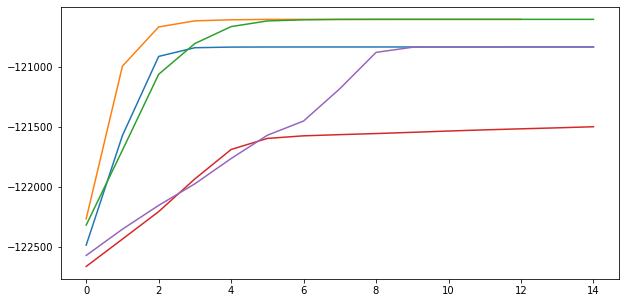

In [126]:
np.seterr(divide='ignore', invalid='ignore')
records = plot_log_likes(X, len(data[0]))

# Question 2

draw a sequence logo visualization of the foreground motif your model learns, ψ k,p . You could try LogoMaker, a
Python library (https://logomaker.readthedocs.io/en/latest/). Alternatively, there are a number of web servers
for doing this; you could draw samples from your foreground model, and input those drawn sequences into e.g.
the WebLogo server (https://weblogo.berkeley.edu).

In [127]:
import logomaker
import pandas as pd

In [128]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, X, len(data[0]), 5)

### Plot of ELBOs during training

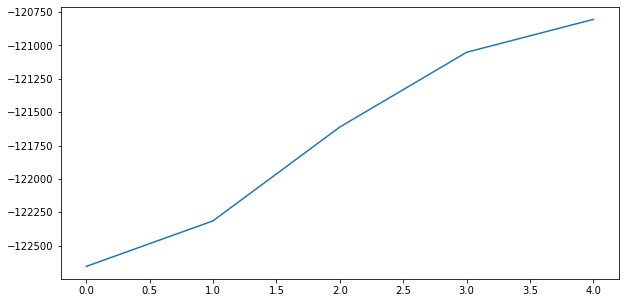

In [129]:
plt.plot(log_like)

### Plot of $\lambda_{j}$ at end of training

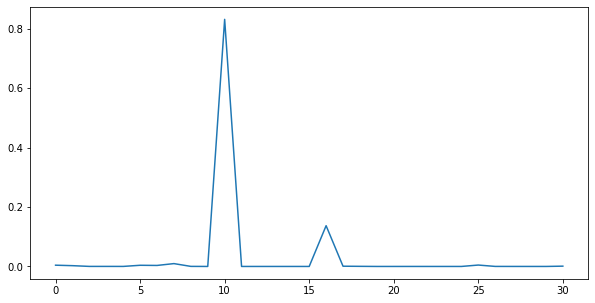

In [130]:
plt.plot(lambda_j)

In [131]:
def make_logo(psi_1):
    psi_1_df = pd.DataFrame(psi_1, columns=['A', 'T', 'G', 'C'])
    psi_1_df.index.name = 'pos'
    return logomaker.Logo(psi_1_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold'
                         )

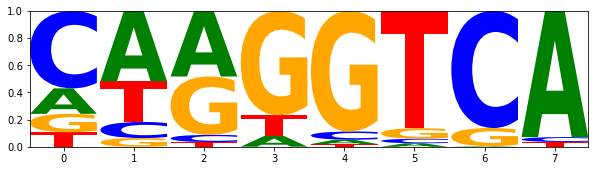

In [132]:
make_logo(psi_1)

# Question 3

Now run your model using model random initializations. How do the model parameters ψ k,p compare across runs?
What about their log likelihoods

## Comparison of $\psi$ between different random initializations

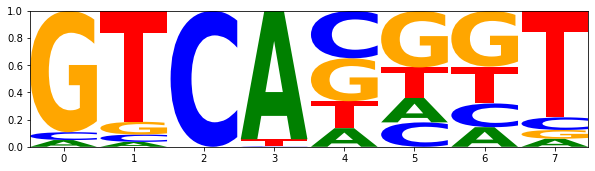

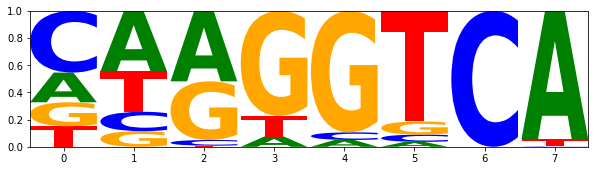

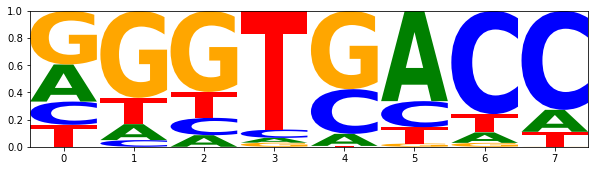

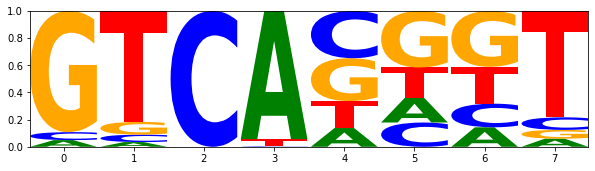

In [134]:
for r in records:
    try:
        make_logo(r['psi_1'])
    except Exception:
        continue

Using different seeds and therefore starting the model at different "positions" seems to have a pretty significant effect on the final motif that it ends up learning possibly meaning that there are lots of local mins to be found.

## Comparison of log likelihoods between different random initializations

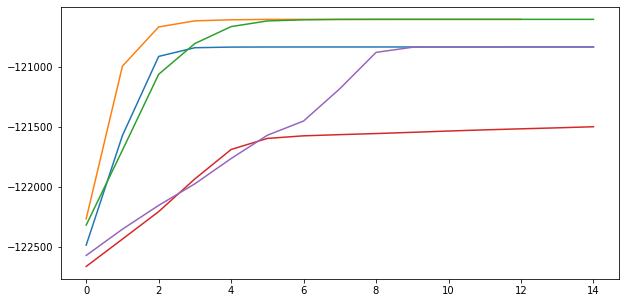

In [135]:
for r in records:
    plt.plot(r['log_like'])

# Question 4

Plot a figure that shows the distribution over C i,j for a few of the input sequences, and compare that (in the
visualization) to the ground truth. How close was your model to predicting the real motif location?

Download motif location data.

In [136]:
import requests
import io
import seaborn as sns

In [137]:
sequence_padded_motifs = pd.read_csv(
    io.StringIO(requests.get(sequence_motiflocation_padded_txt).text), sep=",", header=None).to_numpy()

Set all values in posterior to zero except the max value and create a heatmap of these results.

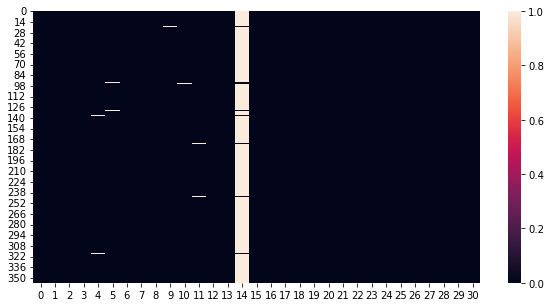

In [138]:
records[0]['E_Cij']
max_prob = np.zeros_like(records[0]['E_Cij'])
max_prob[np.arange(len(records[0]['E_Cij'])), records[0]['E_Cij'].argmax(1)] = 1

ax = sns.heatmap(max_prob)
plt.show()

<AxesSubplot:>

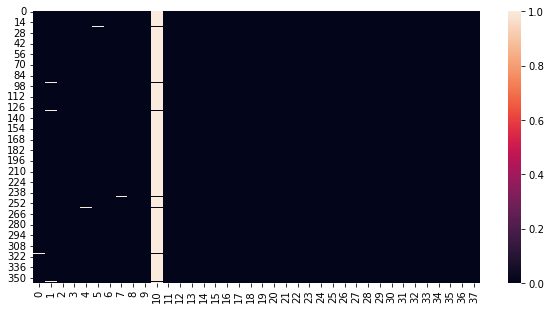

In [139]:
sns.heatmap(sequence_padded_motifs)

The model is for sure converging on a specific motif position and I am pretty sure it is the same that is shown in the ground truth. I think there is differences in the length of the motif (number of motifs is different between the two plots).

# Question 5

Train your model using 80% of the data, holding out the remaining 20%. Evaluate the log likelihood of your held
out data using the model you implemented in this assignment, and compare it to the log likelihood from the simple
latent model we used in class, using the same training/held out data. Which one is better?

In [140]:
def divide_data(X):
    training_split = int(X.shape[0] * 0.80)
    return X[:training_split], X[training_split:]

Train the EM motif model.

In [141]:
X_train, X_test = divide_data(X)

In [142]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, X_train, len(data[0]), number_iters=7)

### Log likelihood motif model over 7 training iterations

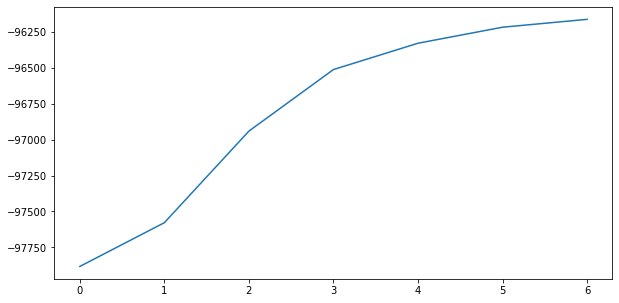

In [143]:
plt.plot(log_like)

Code below directly stolen from Gerald's Colab notebook

In [145]:
# -*- coding: utf-8 -*-
"""EM.1 - Simple latent sequence model.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1fxNklSRd1g5g7cZm7MK9HG1wDHZektWU

## The EM algorithm for a simple sequence model

Below is an example implementation of the EM algorithm for the following probabilistic model, in which we assume we have $N$ input sequences, each of length $L$, and the sequences are independent mixtures of bases drawn from $K$ different distributions. $\lambda_k$ is the prior probability of a base being drawn from distribution $k$, and $\psi_b^{(k)}$ is the probability of drawing base $b$ from distribution $k$.

$C_{i,j} \sim \mbox{Discrete}(\vec{\lambda})$

$\vec{\lambda}=[\lambda_1 ... \lambda_K]$

$X_{i,j}|C_{i,j} \sim \mbox{Discrete}(\vec{\psi}^{(C_{i,j})})$

$\vec{\psi}^{(k)} = [\psi_A^{(k)} \psi_C^{(k)} \psi_G^{(k)} \psi_T^{(k)}]$

# *Utility function for reading in data from course Box folder
"""

import pandas as pd
import io
import requests
from tqdm import tqdm
import numpy as np

from sklearn.preprocessing import OneHotEncoder

#----------------------------------------
#from Chenxi Liu
#function for downloading sequence data from Box and converting to one-hot encoding
#note this function actually returns the summary statistics over the data, which is
#just the total number of each bases across all input sequences for our simple 
#latent variable model.
#
# this function by default returns a summary of all data.
def get_sequence(url, categories=['A', 'C', 'G', 'T']):
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)
  
  for ii in range(len(categories)):
    data_ss[0,ii] = np.sum(data[:,:,ii])

  return data, data_ss

#----------------------------------------
#modification of function above, to return a 'training' and 'testing' set (randomly split).
def get_sequence_traintest(url, categories=['A', 'C', 'G', 'T'], FRACTION_TRAINING=0.8):
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss_train = np.zeros((1, len(categories)))
  data_ss_test = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)


   #randomly permute rows of matrix
  np.random.shuffle(data)

  train_indices = np.arange(start=0,stop=round(FRACTION_TRAINING*data.shape[0]))
  test_indices = np.arange(start=round(FRACTION_TRAINING*data.shape[0]), stop=data.shape[0])
  
  for ii in range(len(categories)):
    data_ss_train[0,ii] = np.sum(data[train_indices,:,ii])
    data_ss_test[0,ii] = np.sum(data[test_indices,:,ii])

  return data_ss_train, data_ss_test

"""# Core EM code"""

#----------------------------------------
# parameter initialization
# psi: a 4xNUM_MODELS matrix of psi parameters
# lmbda: an array of length NUM_MODELS

import math

def init_EM(NUM_MODELS):
  lmbda = np.random.uniform(0, 1,size=(NUM_MODELS,))
  lmbda = lmbda/np.sum(lmbda)
  psi = np.random.uniform(0,1,size=(4,NUM_MODELS))
  psi = psi/psi.sum(axis=0)
  theta = {'lmbda': lmbda, 'psi': psi}
  return(theta)

#----------------------------------------
# compute posteriors P(C_ij | X_ij, theta)
# return a 4 x NUM_MODELS object PP, where PP[aa,bb] = P(C_ij = bb | X_ij = aa, theta)
def E_step(theta):
  unnormalized_posteriors = theta['psi']*theta['lmbda']
  normalized_posteriors = (unnormalized_posteriors.T/unnormalized_posteriors.sum(axis=1)).T
  return(normalized_posteriors)

#----------------------------------------
# compute MLE of psi, lambda
# theta: current parameter set used to calculate posteriors
# XXss: summary statistics of # of bases across all training sequences
# return a dictionary containing psi, lambda
def M_step(XXss, posteriors):
  unnormalized_psi = (posteriors.T*XXss).T
  unnormalized_lambda = unnormalized_psi.sum(axis=0)
  psi = unnormalized_psi/unnormalized_psi.sum(axis=0)
  lmbda = unnormalized_lambda/np.sum(unnormalized_lambda)
  return({'lmbda': lmbda, 'psi': psi})

#----------------------------------------
# compute log likelihood, given posteriors based off the current parameter set theta (so KL = 0)
def loglikelihood(XXss, theta, posteriors):
  #matrix JP of weighted joint log probabilities, size 4xNUM_MODELS, where JP[aa,bb] = E[Cij=bb] log P(Xij = aa, Cij = bb | theta) 
  weighted_log_joint_prob = (np.log(theta['psi'])+np.log(theta['lmbda']))*posteriors  
  weighted_log_joint_prob[np.where(posteriors == 0)]=0; #putting in a check in case some posteriors are 0 (because some psi are 0) - 0log0 = 0 (otherwise we will get nan)
  
  expected_complete_LL = np.sum(weighted_log_joint_prob.T*XXss)
  #entropy term calculation needs to be careful since 0log0 = 0, but coded naively will give nan
  qlogq = posteriors * np.log(posteriors);
  qlogq[np.where(posteriors == 0)] = 0 #0log0 = 0
  return (expected_complete_LL - np.sum(np.sum(qlogq,axis=1) * XXss)) #log likelihood = ELBO + entropy, when q=p

"""# Get data"""

#URL for at_gc_sequences.txt - this is a single sequence:
# ATTTAATATAAAATTTGGCCGCCATAAAAAAA
#https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt
#URL for sequence.padded.txt - the real binding site data
#https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt
#URL for sequence.motiflocation.padded.txt - the location of the binding sites from sequence.padded.txt
#https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt

sequences_padded_train, sequences_padded_test = get_sequence_traintest('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')
#XXss_at_gc, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt')
XXss_sequences_padded, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')

#get the locations of the binding sites
CC_sequences_padded = pd.read_csv(io.StringIO(requests.get('https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt').text), sep=",", header=None).to_numpy()

"""# Run EM"""

np.random.seed(1)
#XXss = XXss_at_gc
XXss = sequences_padded_train
theta = init_EM(NUM_MODELS = 3)
basic_logs = []
#train
for ii in range(3):  
  posteriors = E_step(theta);  
  basic_logs.append(loglikelihood(XXss, theta, posteriors))
  theta = M_step(XXss, posteriors);

#evaluate on held-out test data
posteriors = E_step(theta)
print('held-out likelihood:', loglikelihood(sequences_padded_test, theta, posteriors))

100%|████████████████████████████████████████| 357/357 [00:00<00:00, 785.68it/s]


held-out likelihood: -3739.582277428004


### Plot likelihoods of basic model

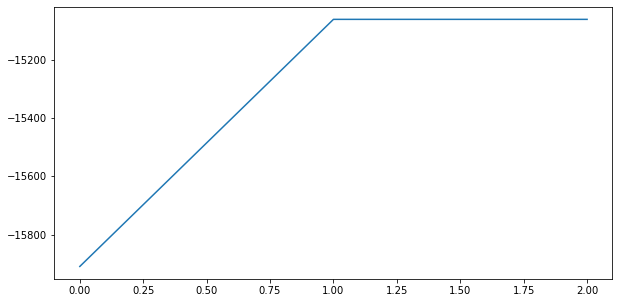

In [146]:
plt.plot(basic_logs)

# Question 6

Train your model on the atgcsequences.txt file (that had a GC-rich region embedded between two flanking AT-rich
regions). Does the model work better?

In [98]:
r = requests.get(at_gc_sequences_txt).text.strip()
gc_X = encode_data([r])

In [101]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, gc_X, len(r), number_iters=3)

### Plot of $\lambda_{j}$ for GC rich sequence

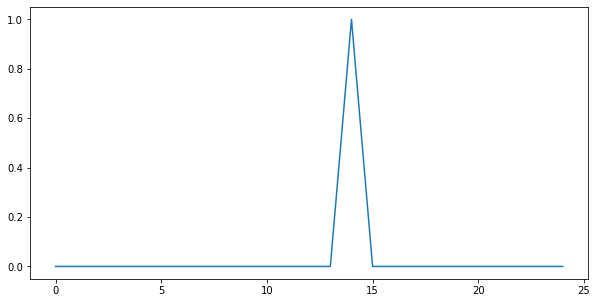

In [102]:
plt.plot(lambda_j)

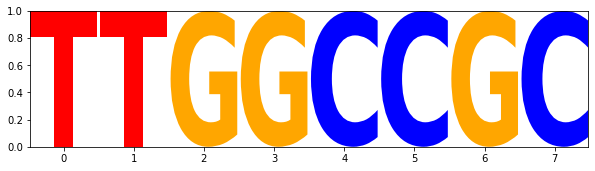

In [103]:
make_logo(psi_1)

I am not sure if the model is working better since we are only testing one sequence. But when looking at the $lambda_{j}$ term compared to when the non-GC rich sequences are included the spike in probability is much more defined. I am not sure if this is due to this sequence working better or the fact there  is only one sequence to train on. 

# Question 7

The original training set in sequence.padded.txt has 357 sequences. Randomly sample another 357 sequences of
the same length (just from a simple generator, that produces each base at equal frequency) and train the model
with all data. Does it still recover the same motif? What if you add 3000 randomly generated sequences instead?

In [78]:
def random_sequence_generator(*args):
    rand_seqs = [''.join(i) for i in np.random.choice(['A', 'T', 'G', 'C'], size=args)]
    return encode_data(rand_seqs)
        

In [79]:
rand_seqs = random_sequence_generator(X.shape[0], len(data[0]))

In [80]:
mixed_data = np.concatenate((X, rand_seqs))

Train model on mixed data (50% random sequence).

In [81]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, mixed_data, len(data[0]), number_iters=5)

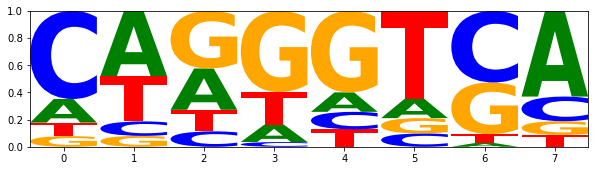

In [82]:
make_logo(psi_1)

Overall this logo looks pretty similar to the one generated originally, implying that the model is somewhat robust to noise in the data.

Add 3000 randomly generated sequences.

In [83]:
lots_random_seqs = random_sequence_generator(3000, len(data[0]))

In [84]:
dilute_data = np.concatenate((X, lots_random_seqs))

In [88]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, dilute_data, len(data[0]), number_iters=5)

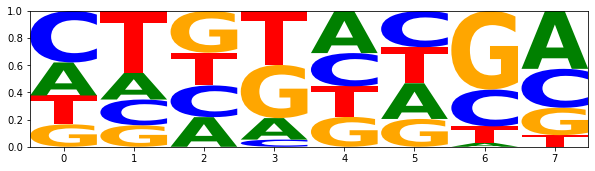

In [89]:
make_logo(psi_1)

With 3000 random sequences the signal seems to get lost in the noise and the motif looks closer to random sequences.